In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F87153%2F200743%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240406%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240406T173525Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D60c51604f6025ddee8982e4d226561c3ca7b67732b68591688298391a7a7432613db196c7a2c318eaa7b5323cfb7ddae1ceadf6d58ebd8b6c04b8d5b74109d18f952962f381c5b6d0d393059c97e2c0a37de995bebf33d62c5f7b1dc02de6e71880dd63e8e866879bbf4b3f92982e435ebc1abab1d723cdbfffa01f2955ecc2df015f4f0d6facb9e033ab2712965689fcbf62a120e3001fbd9baddd1c86bc59a7829a3ab20f5222eca36a1b18a53a7fc21618eed04f195b5d8f6276348efaf6be692b0235dc28995f6f52772da44521d60574a30687355ac75b2e22ae0ef18de27ee79ef798af630962420df6a4dceec34bb71b42f1aae2c5c6e5c5fc1001dfe'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 708172590 bytes downloaded
Downloaded and uncompressed: 
Data source import complete.


## Classification using Keras
In this notebook, I'll work with the Malaria Cell Images dataset to classify cells as either Parasitized or Uninfected. I'll use Convolutional Neural Networks to make the classification.

In [ ]:
import numpy as np
np.random.seed(1000)
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

In [ ]:
import keras
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.models import Sequential

In [ ]:
import os
import cv2
from PIL import Image

In [ ]:
DATA_DIR = '../input/cell_images/cell_images/'
SIZE = 64
dataset = []
label = []

## Parasitized cell images
I iterate through all images in the Parasitized folder. I check if the file extension of the file being read is png. I then resize the image to 64x64 and then save it to the dataset variable as numpy array. The label for this is set as 0.

In [ ]:
parasitized_images = os.listdir(DATA_DIR + 'Parasitized/')
for i, image_name in enumerate(parasitized_images):
    try:
        if (image_name.split('.')[1] == 'png'):
            image = cv2.imread(DATA_DIR + 'Parasitized/' + image_name)
            image = Image.fromarray(image, 'RGB')
            image = image.resize((SIZE, SIZE))
            dataset.append(np.array(image))
            label.append(0)
    except Exception:
        print("Could not read image {} with name {}".format(i, image_name))


## Uninfected cell images
I iterate through all images in the Uninfected folder. I check if the file extension of the file being read is png. I then resize the image to 64x64 and then save it to the dataset variable as numpy array. The label for this is set as 0.

In [ ]:
uninfected_images = os.listdir(DATA_DIR + 'Uninfected/')
for i, image_name in enumerate(uninfected_images):
    try:
        if (image_name.split('.')[1] == 'png'):
            image = cv2.imread(DATA_DIR + 'Uninfected/' + image_name)
            image = Image.fromarray(image, 'RGB')
            image = image.resize((SIZE, SIZE))
            dataset.append(np.array(image))
            label.append(1)
    except Exception:
        print("Could not read image {} with name {}".format(i, image_name))

## Parasitized images
I randomly select 5 values from the number of parasitized images and then display them in a row.

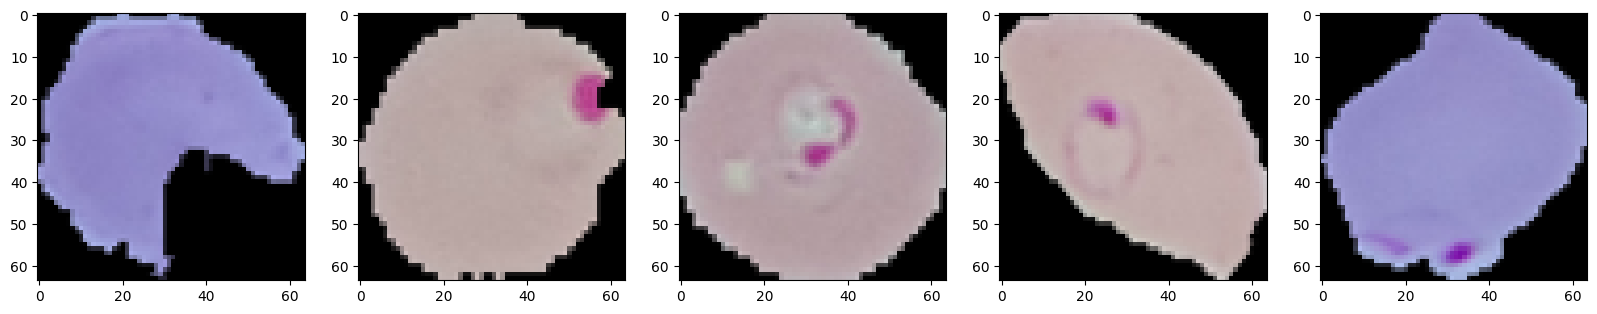

In [ ]:
plt.figure(figsize = (20, 12))
for index, image_index in enumerate(np.random.randint(len(parasitized_images), size = 5)):
    plt.subplot(1, 5, index+1)
    plt.imshow(dataset[image_index])

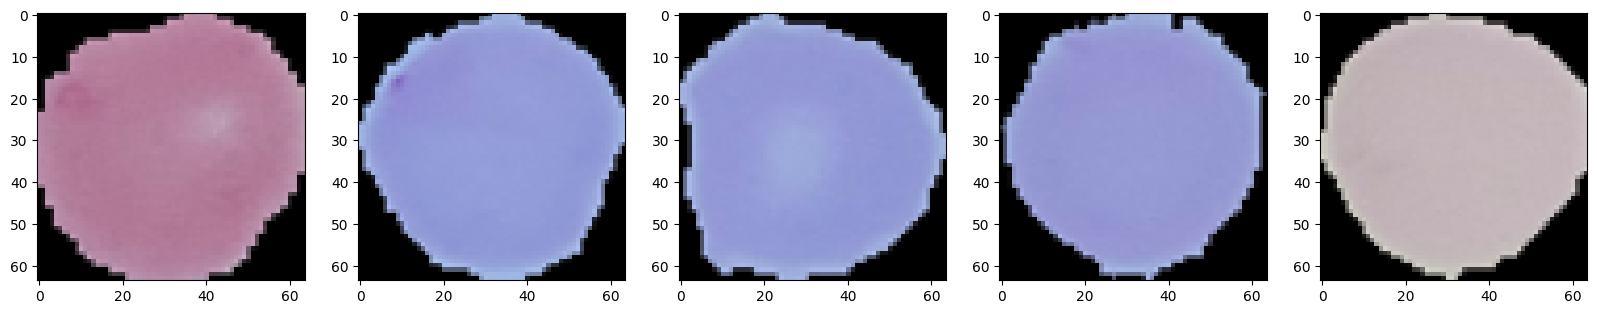

In [ ]:
plt.figure(figsize = (20, 12))
for index, image_index in enumerate(np.random.randint(len(uninfected_images), size = 5)):
    plt.subplot(1, 5, index+1)
    plt.imshow(dataset[len(parasitized_images) + image_index])

In [ ]:
classifier = None
classifier = Sequential()
classifier.add(Convolution2D(32, (3, 3), input_shape = (SIZE, SIZE, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
classifier.add(BatchNormalization(axis = -1))
classifier.add(Dropout(0.2))
classifier.add(Convolution2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
classifier.add(BatchNormalization(axis = -1))
classifier.add(Dropout(0.2))
classifier.add(Flatten())
classifier.add(Dense(activation = 'relu', units=512))
classifier.add(BatchNormalization(axis = -1))
classifier.add(Dropout(0.2))
classifier.add(Dense(activation = 'relu', units=256))
classifier.add(BatchNormalization(axis = -1))
classifier.add(Dropout(0.2))
classifier.add(Dense(activation = 'sigmoid', units=2))
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(classifier.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 31, 31, 32)        128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0

In [ ]:
from keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(dataset, to_categorical(np.array(label)), test_size = 0.20, random_state = 0)

In [ ]:
history = classifier.fit(np.array(X_train),
                         y_train,
                         batch_size = 64,
                         verbose = 2,
                         epochs = 50,
                         validation_split = 0.1,
                         shuffle = False)

Epoch 1/50
311/311 - 125s - loss: 0.4886 - accuracy: 0.7873 - val_loss: 1.4889 - val_accuracy: 0.7329 - 125s/epoch - 403ms/step
Epoch 2/50
311/311 - 110s - loss: 0.2369 - accuracy: 0.9118 - val_loss: 0.2998 - val_accuracy: 0.8993 - 110s/epoch - 353ms/step
Epoch 3/50
311/311 - 104s - loss: 0.1946 - accuracy: 0.9283 - val_loss: 0.1638 - val_accuracy: 0.9415 - 104s/epoch - 334ms/step
Epoch 4/50
311/311 - 102s - loss: 0.1732 - accuracy: 0.9369 - val_loss: 0.1907 - val_accuracy: 0.9338 - 102s/epoch - 329ms/step
Epoch 5/50
311/311 - 103s - loss: 0.1540 - accuracy: 0.9438 - val_loss: 0.1738 - val_accuracy: 0.9347 - 103s/epoch - 331ms/step
Epoch 6/50
311/311 - 104s - loss: 0.1360 - accuracy: 0.9505 - val_loss: 0.1908 - val_accuracy: 0.9311 - 104s/epoch - 333ms/step
Epoch 7/50
311/311 - 107s - loss: 0.1098 - accuracy: 0.9602 - val_loss: 0.1678 - val_accuracy: 0.9429 - 107s/epoch - 343ms/step
Epoch 8/50
311/311 - 104s - loss: 0.0976 - accuracy: 0.9645 - val_loss: 0.1706 - val_accuracy: 0.9424 - 

In [13]:
print("Test_Accuracy: {:.2f}%".format(classifier.evaluate(np.array(X_test), np.array(y_test))[1]*100))

173/173 [==============================] - 7s 40ms/step - loss: 0.3217 - accuracy: 0.9488
Test_Accuracy: 94.88%


In [14]:
from keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(rescale = 1/255,
                                     zoom_range = 0.3,
                                     horizontal_flip = True,
                                     rotation_range = 30)

test_generator = ImageDataGenerator(rescale = 1/255)

train_generator = train_generator.flow(np.array(X_train),
                                       y_train,
                                       batch_size = 64,
                                       shuffle = False)

test_generator = test_generator.flow(np.array(X_test),
                                     y_test,
                                     batch_size = 64,
                                     shuffle = False)

In [15]:
history = classifier.fit_generator(train_generator,
                                   steps_per_epoch = len(X_train)/64,
                                   epochs = 50,
                                   shuffle = False)

Epoch 1/50


<ipython-input-15-60a22b11ead1>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = classifier.fit_generator(train_generator,


344/344 [==============================] - 140s 402ms/step - loss: 0.2527 - accuracy: 0.9226
Epoch 2/50
344/344 [==============================] - 137s 397ms/step - loss: 0.1886 - accuracy: 0.9350
Epoch 3/50
344/344 [==============================] - 138s 402ms/step - loss: 0.1762 - accuracy: 0.9387
Epoch 4/50
344/344 [==============================] - 135s 393ms/step - loss: 0.1685 - accuracy: 0.9407
Epoch 5/50
344/344 [==============================] - 136s 395ms/step - loss: 0.1678 - accuracy: 0.9429
Epoch 6/50
344/344 [==============================] - 139s 404ms/step - loss: 0.1605 - accuracy: 0.9457
Epoch 7/50
344/344 [==============================] - 140s 407ms/step - loss: 0.1570 - accuracy: 0.9465
Epoch 8/50
344/344 [==============================] - 142s 411ms/step - loss: 0.1546 - accuracy: 0.9480
Epoch 9/50
344/344 [==============================] - 139s 402ms/step - loss: 0.1545 - accuracy: 0.9477
Epoch 10/50
344/344 [==============================] - 141s 409ms/step - lo

In [17]:
print("Test_Accuracy(after augmentation): {:.2f}%".format(classifier.evaluate_generator(test_generator, steps = len(X_test), verbose = 1)[1]*100))

   1/5512 [..............................] - ETA: 11:07 - loss: 0.0606 - accuracy: 1.0000

<ipython-input-17-503e42ccb2c9>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  print("Test_Accuracy(after augmentation): {:.2f}%".format(classifier.evaluate_generator(test_generator, steps = len(X_test), verbose = 1)[1]*100))


  86/5512 [..............................] - ETA: 8:38 - loss: 0.1392 - accuracy: 0.9533

5512/5512 [==============================] - 8s 1ms/step - loss: 0.1390 - accuracy: 0.9534
Test_Accuracy(after augmentation): 95.34%


## Conclusion
In this notebook, I worked with the Malaria Cell Images dataset and applied Convolutional Neural Networks using Keras. I observed high accuracy which further increased with data augmentation.